In [1]:
!pip install -e ..

Obtaining file:///home_nfs/paul/dev/skewers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: skewers
    Found existing installation: skewers 0.4.0
    Uninstalling skewers-0.4.0:
      Successfully uninstalled skewers-0.4.0
  Running setup.py develop for skewers


## Skewers

In [2]:
seed = 42
num_param_dimensions = 100  # num DoF arm
init_batch_size = 100
batch_size = 1024
num_iterations = 50
grid_shape = (20, 20)
min_param = 0.0
max_param = 1.0
min_bd = 0.0
max_bd = 1.0

### Eval: QDax

In [3]:
import jax
import functools
from qdax.tasks.arm import arm_scoring_function
from qdax.utils.metrics import default_qd_metrics

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Define a metrics function
metrics_fn = functools.partial(
    default_qd_metrics,
    qd_offset=0.0,
)

scoring_function=arm_scoring_function

init_variables = jax.random.uniform(
    random_key,
    shape=(init_batch_size, num_param_dimensions),
    minval=min_param,
    maxval=max_param,
)

Matplotlib created a temporary cache directory at /tmp/matplotlib-ypb0xlio because the default path (/home_nfs/paul/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home_nfs/paul/dev/skewers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Algo: PyRibs

In [4]:
import numpy as np

from ribs.archives import GridArchive
from ribs.emitters import EvolutionStrategyEmitter
from ribs.schedulers import Scheduler

archive = GridArchive(
    solution_dim=num_param_dimensions,
    dims=grid_shape,
    ranges=[(min_bd, max_bd)] * len(grid_shape),
)

emitters = [
    EvolutionStrategyEmitter(
        archive=archive,
        x0=[0.0] * num_param_dimensions,
        sigma0=1.0,  # Initial step size.
        ranker="2imp",
        batch_size=30,  # If we do not specify a batch size, the emitter will
                        # automatically use a batch size equal to the default
                        # population size of CMA-ES.
    ) for _ in range(5)  # Create 5 separate emitters.
]


print(emitters[0]._batch_size)
scheduler = Scheduler(archive, emitters)

30


### Link: Skewers

In [5]:
from skewers.evaluator import SkewersEvaluator

# Instantiate evaluator
evaluator = SkewersEvaluator(
    scoring_function=scoring_function,
    metrics_function=metrics_fn,
    archive=archive,
    init_variables=init_variables,
)

Using DummyReshaper


In [6]:
from tqdm import tqdm

for itr in tqdm(range(1000)):
    solutions = scheduler.ask()

    # Optimize the 10D negative Sphere function.
    objective_batch, measures_batch = evaluator.evaluate(solutions)

    scheduler.tell(objective_batch, measures_batch)

100%|██████████| 1000/1000 [00:04<00:00, 207.98it/s]


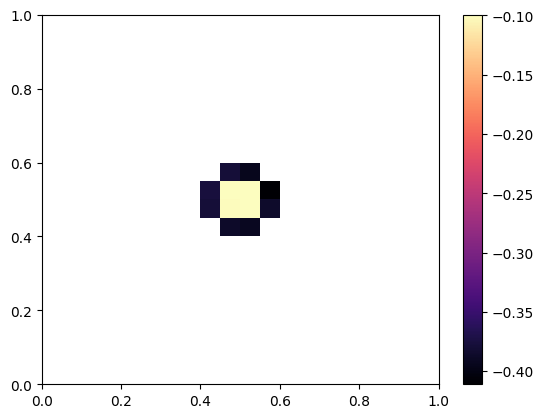

In [7]:
import matplotlib.pyplot as plt
from ribs.visualize import grid_archive_heatmap
%matplotlib inline

grid_archive_heatmap(archive)
plt.show()

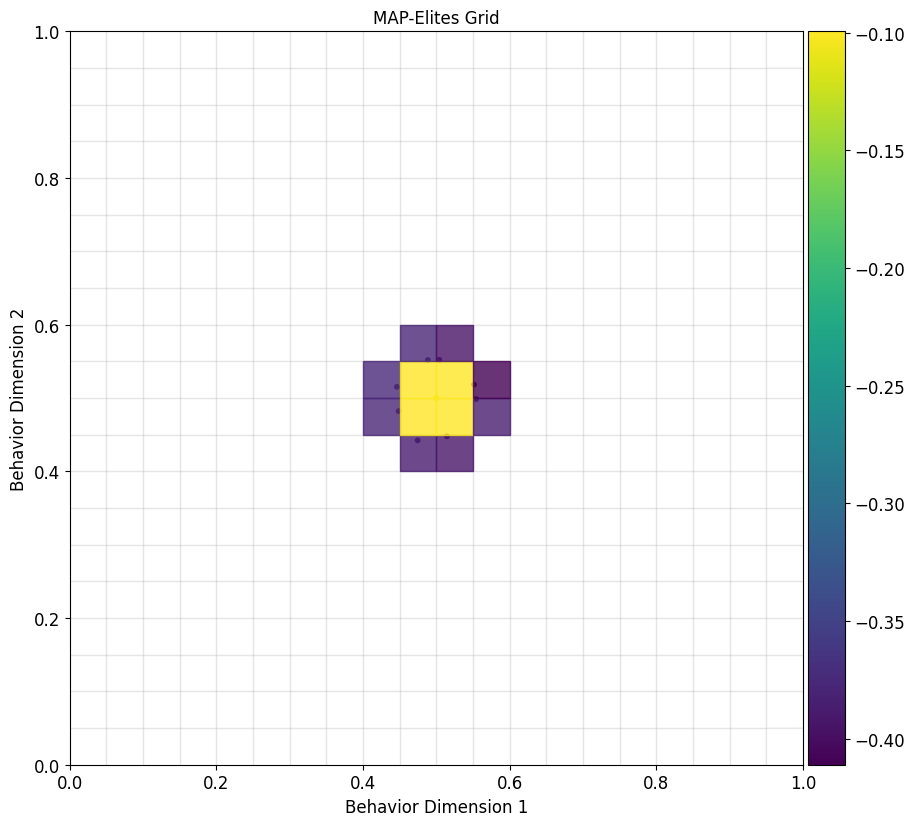

In [8]:
from qdax.utils.plotting import plot_2d_map_elites_repertoire
repertoire = evaluator.repertoire

fig, axes = plot_2d_map_elites_repertoire(
    centroids=repertoire.centroids,
    repertoire_fitnesses=repertoire.fitnesses,
    minval=min_bd,
    maxval=max_bd,
    repertoire_descriptors=repertoire.descriptors,
    # vmin=-0.2,
    # vmax=0.0,
)

plt.show()